In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
import os
import neptune
from neptune.utils import stringify_unsupported

import scalpDeepModels as sdm

import importlib

plt.style.use('ggplot')

# PARAMETERS - GENERAL

In [2]:
stftSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/freqRTheta.npz'
timeDomainSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeDomain.npz'
timeFreqSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeFreqRTheta.npz'

modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/'

neptuneProject = 'jettinger35/predictScalp'
api_token = os.environ.get('NEPTUNE_API_TOKEN')

subsampleFreq = 128   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# PARAMETERS - TRAINING

In [3]:
epochs = 5000
batch_size = 1024
learningRate = 1e-3
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optChoice = 'adam'

patience = 5000

# UTILITY FUNCTIONS

In [4]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

# LOAD NUMPY DATA ARRAYS

In [5]:
dataSwitch = 'time'

if dataSwitch == 'freq':
    # STFT DATA

    npzfile = np.load(stftSavePath)
    x_trainRTheta = npzfile['x_trainRTheta']
    x_validRTheta = npzfile['x_validRTheta'] 
    y_trainRTheta = npzfile['y_trainRTheta'] 
    y_validRTheta = npzfile['y_validRTheta']

    trainXTensor = torch.Tensor(x_trainRTheta)
    trainYTensor = torch.Tensor(y_trainRTheta)
    validXTensor = torch.Tensor(x_validRTheta)
    validYTensor = torch.Tensor(y_validRTheta)

elif dataSwitch == 'time':
    # TIME DOMAIN DATA

    npzfile = np.load(timeDomainSavePath)
    xTrainTimeDomain = npzfile['xTrainTimeDomain']
    xValidTimeDomain = npzfile['xValidTimeDomain'] 
    yTrainTimeDomain = npzfile['yTrainTimeDomain'] 
    yValidTimeDomain = npzfile['yValidTimeDomain']

    trainXTensor = torch.Tensor(xTrainTimeDomain)
    trainYTensor = torch.Tensor(yTrainTimeDomain)
    validXTensor = torch.Tensor(xValidTimeDomain)
    validYTensor = torch.Tensor(yValidTimeDomain)
    
elif dataSwitch == 'timeFreq':
    
    npzfile = np.load(timeFreqSavePath)
    xTrain = npzfile['x_trainTimeFreq']
    xValid = npzfile['x_validTimeFreq'] 
    yTrain = npzfile['y_trainTimeFreq'] 
    yValid = npzfile['y_validTimeFreq']

    trainXTensor = torch.Tensor(xTrain)
    trainYTensor = torch.Tensor(yTrain)
    validXTensor = torch.Tensor(xValid)
    validYTensor = torch.Tensor(yValid)

In [6]:
# CREATE PYTORCH DATALOADERS

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

validDataset = TensorDataset(validXTensor,validYTensor)
validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)


print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
print("\ntest: ")
for X, y in validDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train: 
Shape of X [N, C, H, W]: torch.Size([1024, 5655])
Shape of y: torch.Size([1024, 1]) torch.float32

test: 
Shape of X [N, C, H, W]: torch.Size([1024, 5655])
Shape of y: torch.Size([1024, 1]) torch.float32


# DEFINE OR LOAD THE MODEL

In [7]:
# DEFINE MODEL

modelID = None

if modelID != None:
    model = torch.jit.load(modelPath + 'model_%s.pt' % str(modelID))
    bestTestLoss = sdm.test(validDataLoader, model, loss_fn, device)
else:
    importlib.reload(sdm) # reload in case we've made any architecture changes
    
    modelID = np.random.randint(0, 10**6)
    
    # DEFINE ARCHITECTURE HERE
    inputSize = trainXTensor.shape[1]
    hiddenLayerSizes = [512,512,512,512,512,512]
    
    layerDict = sdm.listToOrderedDict_1([inputSize] + hiddenLayerSizes)
    #layerDict = sdm.residualAddDict(inputSize, 512, 5)
    #layerDict = sdm.residualConcatDict(inputSize, hiddenLayerSizes)
    
    model = nn.Sequential(layerDict)
    bestTestLoss = float('inf')
    
print("Model ID: " + str(modelID))
print("Number of parameters: ", sdm.count_parameters(model))
model = model.to(device)
print(model)

Model ID: 982815
Number of parameters:  3963439
Sequential(
  (bn0): BatchNorm1d(5655, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l0): Linear(in_features=5655, out_features=512, bias=True)
  (r0): ReLU()
  (d0): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_features=512, out_features=512, bias=True)
  (r1): ReLU()
  (d1): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=512, out_features=512, bias=True)
  (r2): ReLU()
  (d2): Dropout(p=0.5, inplace=False)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Linear(in_features=512, out_features=512, bias=True)
  (r3): ReLU()
  (d3): Dropout(p=0.5, inplace=False)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=512, 

# TRAIN (LOG DATA TO NEPTUNE)

In [8]:
if optChoice == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
elif optChoice == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
else:
    optimizer = None
    print('no optimizer chosen...')

run = neptune.init_run(
    project=neptuneProject,
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

PARAMS = {
    "modelID": modelID,
    "batch_size": batch_size,
    "learning_rate": learningRate,
    "optimizer": optChoice,
    "patience": patience,
    "subsampleFreq": subsampleFreq,
    "secondsInWindow": secondsInWindow,
    "nperseg": nperseg,
    "noverlap": noverlap,
    "window": stringify_unsupported(window),
    "loss_fn": stringify_unsupported(loss_fn),
    "architectureString": str(model),
    "numParameters": sdm.count_parameters(model)
}
run["parameters"] = PARAMS

noImprovementCount = 0

#epochs = 2

try:
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = sdm.train(trainDataLoader, model, loss_fn, optimizer, device)
        test_loss = sdm.test(validDataLoader, model, loss_fn, device)

        if test_loss < bestTestLoss:
            noImprovementCount = 0
            bestTestLoss = test_loss
            
            model_scripted = torch.jit.script(model) 
            model_scripted.save(modelPath + 'model_%s.pt' % str(modelID))
    
            run["best_test_loss"] =  bestTestLoss
            run["best_test_epoch"] = t
            print("\nSaved a new best model!\n")
        else:
            noImprovementCount = noImprovementCount + 1

        run["train/loss"].append(train_loss)
        run["test/loss"].append(test_loss)

        if noImprovementCount >= patience:   
            print("Early stopping invoked....")
            break

    run.stop()
    print("Done!")
except:
    run.stop()
    print("Training aborted...")

https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-66
Epoch 1
-------------------------------
loss: 0.829233  [ 1024/176128]
Test Error: 
 Avg loss: 0.679717 


Saved a new best model!

Epoch 2
-------------------------------
loss: 0.757629  [ 1024/176128]
Test Error: 
 Avg loss: 0.675505 


Saved a new best model!

Epoch 3
-------------------------------
loss: 0.798541  [ 1024/176128]
Test Error: 
 Avg loss: 0.669964 


Saved a new best model!

Epoch 4
-------------------------------
loss: 0.777038  [ 1024/176128]
Test Error: 
 Avg loss: 0.663156 


Saved a new best model!

Epoch 5
-------------------------------
loss: 0.698888  [ 1024/176128]
Test Error: 
 Avg loss: 0.656167 


Saved a new best model!

Epoch 6
-------------------------------
loss: 0.746138  [ 1024/176128]
Test Error: 
 Avg loss: 0.648799 


Saved a new best model!

Epoch 7
-------------------------------
loss: 0.739126  [ 1024/176128]
Test Error: 
 Avg loss: 0.641775 


Saved a new best model!

Epoch 8
-------

Test Error: 
 Avg loss: 0.465547 

Epoch 66
-------------------------------
loss: 0.464357  [ 1024/176128]
Test Error: 
 Avg loss: 0.463298 

Epoch 67
-------------------------------
loss: 0.477719  [ 1024/176128]
Test Error: 
 Avg loss: 0.461513 


Saved a new best model!

Epoch 68
-------------------------------
loss: 0.485830  [ 1024/176128]
Test Error: 
 Avg loss: 0.460736 


Saved a new best model!

Epoch 69
-------------------------------
loss: 0.458687  [ 1024/176128]
Test Error: 
 Avg loss: 0.462277 

Epoch 70
-------------------------------
loss: 0.464907  [ 1024/176128]
Test Error: 
 Avg loss: 0.462778 

Epoch 71
-------------------------------
loss: 0.460154  [ 1024/176128]
Test Error: 
 Avg loss: 0.459822 


Saved a new best model!

Epoch 72
-------------------------------
loss: 0.461097  [ 1024/176128]
Test Error: 
 Avg loss: 0.454711 


Saved a new best model!

Epoch 73
-------------------------------
loss: 0.492307  [ 1024/176128]
Test Error: 
 Avg loss: 0.451280 


Save

Test Error: 
 Avg loss: 0.433386 

Epoch 136
-------------------------------
loss: 0.435549  [ 1024/176128]
Test Error: 
 Avg loss: 0.431005 

Epoch 137
-------------------------------
loss: 0.453028  [ 1024/176128]
Test Error: 
 Avg loss: 0.422959 

Epoch 138
-------------------------------
loss: 0.442638  [ 1024/176128]
Test Error: 
 Avg loss: 0.413788 


Saved a new best model!

Epoch 139
-------------------------------
loss: 0.393823  [ 1024/176128]
Test Error: 
 Avg loss: 0.415867 

Epoch 140
-------------------------------
loss: 0.421842  [ 1024/176128]
Test Error: 
 Avg loss: 0.425170 

Epoch 141
-------------------------------
loss: 0.414223  [ 1024/176128]
Test Error: 
 Avg loss: 0.428151 

Epoch 142
-------------------------------
loss: 0.442633  [ 1024/176128]
Test Error: 
 Avg loss: 0.423561 

Epoch 143
-------------------------------
loss: 0.409549  [ 1024/176128]
Test Error: 
 Avg loss: 0.418465 

Epoch 144
-------------------------------
loss: 0.440031  [ 1024/176128]
Te

Test Error: 
 Avg loss: 0.405446 

Epoch 209
-------------------------------
loss: 0.381952  [ 1024/176128]
Test Error: 
 Avg loss: 0.405767 

Epoch 210
-------------------------------
loss: 0.426137  [ 1024/176128]
Test Error: 
 Avg loss: 0.403918 


Saved a new best model!

Epoch 211
-------------------------------
loss: 0.388333  [ 1024/176128]
Test Error: 
 Avg loss: 0.403287 


Saved a new best model!

Epoch 212
-------------------------------
loss: 0.414971  [ 1024/176128]
Test Error: 
 Avg loss: 0.403797 

Epoch 213
-------------------------------
loss: 0.384628  [ 1024/176128]
Test Error: 
 Avg loss: 0.404866 

Epoch 214
-------------------------------
loss: 0.392816  [ 1024/176128]
Test Error: 
 Avg loss: 0.405908 

Epoch 215
-------------------------------
loss: 0.400754  [ 1024/176128]
Test Error: 
 Avg loss: 0.406275 

Epoch 216
-------------------------------
loss: 0.385122  [ 1024/176128]
Test Error: 
 Avg loss: 0.404419 

Epoch 217
-------------------------------
loss: 0

Test Error: 
 Avg loss: 0.407723 

Epoch 285
-------------------------------
loss: 0.386351  [ 1024/176128]
Test Error: 
 Avg loss: 0.410841 

Epoch 286
-------------------------------
loss: 0.366865  [ 1024/176128]
Test Error: 
 Avg loss: 0.410830 

Epoch 287
-------------------------------
loss: 0.373037  [ 1024/176128]
Test Error: 
 Avg loss: 0.407158 

Epoch 288
-------------------------------
loss: 0.395135  [ 1024/176128]
Test Error: 
 Avg loss: 0.401667 


Saved a new best model!

Epoch 289
-------------------------------
loss: 0.412316  [ 1024/176128]
Test Error: 
 Avg loss: 0.398634 


Saved a new best model!

Epoch 290
-------------------------------
loss: 0.351128  [ 1024/176128]
Test Error: 
 Avg loss: 0.399135 

Epoch 291
-------------------------------
loss: 0.391482  [ 1024/176128]
Test Error: 
 Avg loss: 0.399760 

Epoch 292
-------------------------------
loss: 0.388072  [ 1024/176128]
Test Error: 
 Avg loss: 0.399597 

Epoch 293
-------------------------------
loss: 0

Test Error: 
 Avg loss: 0.397830 

Epoch 359
-------------------------------
loss: 0.361890  [ 1024/176128]
Test Error: 
 Avg loss: 0.397619 

Epoch 360
-------------------------------
loss: 0.373946  [ 1024/176128]
Test Error: 
 Avg loss: 0.397398 

Epoch 361
-------------------------------
loss: 0.400412  [ 1024/176128]
Test Error: 
 Avg loss: 0.397120 

Epoch 362
-------------------------------
loss: 0.367069  [ 1024/176128]
Test Error: 
 Avg loss: 0.397861 

Epoch 363
-------------------------------
loss: 0.371758  [ 1024/176128]
Test Error: 
 Avg loss: 0.399688 

Epoch 364
-------------------------------
loss: 0.393206  [ 1024/176128]
Test Error: 
 Avg loss: 0.402384 

Epoch 365
-------------------------------
loss: 0.351129  [ 1024/176128]
Test Error: 
 Avg loss: 0.405739 

Epoch 366
-------------------------------
loss: 0.360768  [ 1024/176128]
Test Error: 
 Avg loss: 0.408577 

Epoch 367
-------------------------------
loss: 0.386500  [ 1024/176128]
Test Error: 
 Avg loss: 0.40

Test Error: 
 Avg loss: 0.400148 

Epoch 435
-------------------------------
loss: 0.353776  [ 1024/176128]
Test Error: 
 Avg loss: 0.400878 

Epoch 436
-------------------------------
loss: 0.372344  [ 1024/176128]
Test Error: 
 Avg loss: 0.401404 

Epoch 437
-------------------------------
loss: 0.381031  [ 1024/176128]
Test Error: 
 Avg loss: 0.400412 

Epoch 438
-------------------------------
loss: 0.355015  [ 1024/176128]
Test Error: 
 Avg loss: 0.400447 

Epoch 439
-------------------------------
loss: 0.357157  [ 1024/176128]
Test Error: 
 Avg loss: 0.401718 

Epoch 440
-------------------------------
loss: 0.361782  [ 1024/176128]
Test Error: 
 Avg loss: 0.401677 

Epoch 441
-------------------------------
loss: 0.368694  [ 1024/176128]
Test Error: 
 Avg loss: 0.400080 

Epoch 442
-------------------------------
loss: 0.372610  [ 1024/176128]
Test Error: 
 Avg loss: 0.398756 

Epoch 443
-------------------------------
loss: 0.370607  [ 1024/176128]
Test Error: 
 Avg loss: 0.39

Test Error: 
 Avg loss: 0.394064 

Epoch 511
-------------------------------
loss: 0.359295  [ 1024/176128]
Test Error: 
 Avg loss: 0.394841 

Epoch 512
-------------------------------
loss: 0.354126  [ 1024/176128]
Test Error: 
 Avg loss: 0.396777 

Epoch 513
-------------------------------
loss: 0.378165  [ 1024/176128]
Test Error: 
 Avg loss: 0.397939 

Epoch 514
-------------------------------
loss: 0.367201  [ 1024/176128]
Test Error: 
 Avg loss: 0.396498 

Epoch 515
-------------------------------
loss: 0.346504  [ 1024/176128]
Test Error: 
 Avg loss: 0.396443 

Epoch 516
-------------------------------
loss: 0.362808  [ 1024/176128]
Test Error: 
 Avg loss: 0.396056 

Epoch 517
-------------------------------
loss: 0.352599  [ 1024/176128]
Test Error: 
 Avg loss: 0.395165 

Epoch 518
-------------------------------
loss: 0.359943  [ 1024/176128]
Test Error: 
 Avg loss: 0.395136 

Epoch 519
-------------------------------
loss: 0.358221  [ 1024/176128]
Test Error: 
 Avg loss: 0.39

Test Error: 
 Avg loss: 0.396760 

Epoch 587
-------------------------------
loss: 0.349175  [ 1024/176128]
Test Error: 
 Avg loss: 0.398300 

Epoch 588
-------------------------------
loss: 0.358883  [ 1024/176128]
Test Error: 
 Avg loss: 0.398541 

Epoch 589
-------------------------------
loss: 0.360936  [ 1024/176128]
Test Error: 
 Avg loss: 0.398076 

Epoch 590
-------------------------------
loss: 0.352247  [ 1024/176128]
Test Error: 
 Avg loss: 0.396731 

Epoch 591
-------------------------------
loss: 0.342657  [ 1024/176128]
Test Error: 
 Avg loss: 0.395820 

Epoch 592
-------------------------------
loss: 0.366579  [ 1024/176128]
Test Error: 
 Avg loss: 0.395937 

Epoch 593
-------------------------------
loss: 0.376844  [ 1024/176128]
Test Error: 
 Avg loss: 0.395863 

Epoch 594
-------------------------------
loss: 0.349727  [ 1024/176128]
Test Error: 
 Avg loss: 0.396197 

Epoch 595
-------------------------------
loss: 0.356555  [ 1024/176128]
Test Error: 
 Avg loss: 0.39

Test Error: 
 Avg loss: 0.393927 

Epoch 663
-------------------------------
loss: 0.342674  [ 1024/176128]
Test Error: 
 Avg loss: 0.393299 

Epoch 664
-------------------------------
loss: 0.348933  [ 1024/176128]
Test Error: 
 Avg loss: 0.396377 

Epoch 665
-------------------------------
loss: 0.347349  [ 1024/176128]
Test Error: 
 Avg loss: 0.398484 

Epoch 666
-------------------------------
loss: 0.344966  [ 1024/176128]
Test Error: 
 Avg loss: 0.399020 

Epoch 667
-------------------------------
loss: 0.349816  [ 1024/176128]
Test Error: 
 Avg loss: 0.394265 

Epoch 668
-------------------------------
loss: 0.313084  [ 1024/176128]
Test Error: 
 Avg loss: 0.392480 

Epoch 669
-------------------------------
loss: 0.327477  [ 1024/176128]
Test Error: 
 Avg loss: 0.393710 

Epoch 670
-------------------------------
loss: 0.352831  [ 1024/176128]
Test Error: 
 Avg loss: 0.395634 

Epoch 671
-------------------------------
loss: 0.340656  [ 1024/176128]
Test Error: 
 Avg loss: 0.39

Test Error: 
 Avg loss: 0.396885 

Epoch 739
-------------------------------
loss: 0.307733  [ 1024/176128]
Test Error: 
 Avg loss: 0.395857 

Epoch 740
-------------------------------
loss: 0.312056  [ 1024/176128]
Test Error: 
 Avg loss: 0.395653 

Epoch 741
-------------------------------
loss: 0.335818  [ 1024/176128]
Test Error: 
 Avg loss: 0.395383 

Epoch 742
-------------------------------
loss: 0.343983  [ 1024/176128]
Test Error: 
 Avg loss: 0.395919 

Epoch 743
-------------------------------
loss: 0.349392  [ 1024/176128]
Test Error: 
 Avg loss: 0.395805 

Epoch 744
-------------------------------
loss: 0.339474  [ 1024/176128]
Test Error: 
 Avg loss: 0.395998 

Epoch 745
-------------------------------
loss: 0.326417  [ 1024/176128]
Test Error: 
 Avg loss: 0.394439 

Epoch 746
-------------------------------
loss: 0.330355  [ 1024/176128]
Test Error: 
 Avg loss: 0.394373 

Epoch 747
-------------------------------
loss: 0.325626  [ 1024/176128]
Test Error: 
 Avg loss: 0.39

Test Error: 
 Avg loss: 0.403979 

Epoch 815
-------------------------------
loss: 0.331001  [ 1024/176128]
Test Error: 
 Avg loss: 0.400670 

Epoch 816
-------------------------------
loss: 0.314259  [ 1024/176128]
Test Error: 
 Avg loss: 0.396552 

Epoch 817
-------------------------------
loss: 0.345943  [ 1024/176128]
Test Error: 
 Avg loss: 0.395313 

Epoch 818
-------------------------------
loss: 0.326063  [ 1024/176128]
Test Error: 
 Avg loss: 0.395386 

Epoch 819
-------------------------------
loss: 0.326341  [ 1024/176128]
Test Error: 
 Avg loss: 0.394911 

Epoch 820
-------------------------------
loss: 0.327994  [ 1024/176128]
Test Error: 
 Avg loss: 0.395272 

Epoch 821
-------------------------------
loss: 0.313428  [ 1024/176128]
Test Error: 
 Avg loss: 0.399425 

Epoch 822
-------------------------------
loss: 0.345818  [ 1024/176128]
Test Error: 
 Avg loss: 0.405391 

Epoch 823
-------------------------------
loss: 0.324392  [ 1024/176128]
Test Error: 
 Avg loss: 0.40

Test Error: 
 Avg loss: 0.399724 

Epoch 891
-------------------------------
loss: 0.326286  [ 1024/176128]
Test Error: 
 Avg loss: 0.397868 

Epoch 892
-------------------------------
loss: 0.322751  [ 1024/176128]
Test Error: 
 Avg loss: 0.396737 

Epoch 893
-------------------------------
loss: 0.307778  [ 1024/176128]
Test Error: 
 Avg loss: 0.396443 

Epoch 894
-------------------------------
loss: 0.309435  [ 1024/176128]
Test Error: 
 Avg loss: 0.397019 

Epoch 895
-------------------------------
loss: 0.311040  [ 1024/176128]
Test Error: 
 Avg loss: 0.397032 

Epoch 896
-------------------------------
loss: 0.330194  [ 1024/176128]
Test Error: 
 Avg loss: 0.396901 

Epoch 897
-------------------------------
loss: 0.324192  [ 1024/176128]
Test Error: 
 Avg loss: 0.396512 

Epoch 898
-------------------------------
loss: 0.338175  [ 1024/176128]
Test Error: 
 Avg loss: 0.395928 

Epoch 899
-------------------------------
loss: 0.329158  [ 1024/176128]
Test Error: 
 Avg loss: 0.39

Test Error: 
 Avg loss: 0.398603 

Epoch 967
-------------------------------
loss: 0.334078  [ 1024/176128]
Test Error: 
 Avg loss: 0.398389 

Epoch 968
-------------------------------
loss: 0.328870  [ 1024/176128]
Test Error: 
 Avg loss: 0.398728 

Epoch 969
-------------------------------
loss: 0.311814  [ 1024/176128]
Test Error: 
 Avg loss: 0.397855 

Epoch 970
-------------------------------
loss: 0.321183  [ 1024/176128]
Test Error: 
 Avg loss: 0.397232 

Epoch 971
-------------------------------
loss: 0.321300  [ 1024/176128]
Test Error: 
 Avg loss: 0.398087 

Epoch 972
-------------------------------
loss: 0.308409  [ 1024/176128]
Test Error: 
 Avg loss: 0.399793 

Epoch 973
-------------------------------
loss: 0.310262  [ 1024/176128]
Test Error: 
 Avg loss: 0.400350 

Epoch 974
-------------------------------
loss: 0.306672  [ 1024/176128]
Test Error: 
 Avg loss: 0.400355 

Epoch 975
-------------------------------
loss: 0.313571  [ 1024/176128]
Test Error: 
 Avg loss: 0.40

Test Error: 
 Avg loss: 0.398556 

Epoch 1043
-------------------------------
loss: 0.308288  [ 1024/176128]
Test Error: 
 Avg loss: 0.396911 

Epoch 1044
-------------------------------
loss: 0.299866  [ 1024/176128]
Test Error: 
 Avg loss: 0.395000 

Epoch 1045
-------------------------------
loss: 0.316980  [ 1024/176128]
Test Error: 
 Avg loss: 0.394729 

Epoch 1046
-------------------------------
loss: 0.295892  [ 1024/176128]
Test Error: 
 Avg loss: 0.394878 

Epoch 1047
-------------------------------
loss: 0.325225  [ 1024/176128]
Test Error: 
 Avg loss: 0.395965 

Epoch 1048
-------------------------------
loss: 0.310552  [ 1024/176128]
Test Error: 
 Avg loss: 0.395237 

Epoch 1049
-------------------------------
loss: 0.328959  [ 1024/176128]
Test Error: 
 Avg loss: 0.394168 

Epoch 1050
-------------------------------
loss: 0.309224  [ 1024/176128]
Test Error: 
 Avg loss: 0.394708 

Epoch 1051
-------------------------------
loss: 0.299633  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.397101 

Epoch 1118
-------------------------------
loss: 0.317491  [ 1024/176128]
Test Error: 
 Avg loss: 0.397478 

Epoch 1119
-------------------------------
loss: 0.290903  [ 1024/176128]
Test Error: 
 Avg loss: 0.399797 

Epoch 1120
-------------------------------
loss: 0.333008  [ 1024/176128]
Test Error: 
 Avg loss: 0.398603 

Epoch 1121
-------------------------------
loss: 0.295445  [ 1024/176128]
Test Error: 
 Avg loss: 0.396455 

Epoch 1122
-------------------------------
loss: 0.313927  [ 1024/176128]
Test Error: 
 Avg loss: 0.395720 

Epoch 1123
-------------------------------
loss: 0.317891  [ 1024/176128]
Test Error: 
 Avg loss: 0.396304 

Epoch 1124
-------------------------------
loss: 0.295488  [ 1024/176128]
Test Error: 
 Avg loss: 0.396239 

Epoch 1125
-------------------------------
loss: 0.326617  [ 1024/176128]
Test Error: 
 Avg loss: 0.396780 

Epoch 1126
-------------------------------
loss: 0.304679  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.402939 

Epoch 1194
-------------------------------
loss: 0.313576  [ 1024/176128]
Test Error: 
 Avg loss: 0.403802 

Epoch 1195
-------------------------------
loss: 0.287374  [ 1024/176128]
Test Error: 
 Avg loss: 0.404185 

Epoch 1196
-------------------------------
loss: 0.289853  [ 1024/176128]
Test Error: 
 Avg loss: 0.404376 

Epoch 1197
-------------------------------
loss: 0.289074  [ 1024/176128]
Test Error: 
 Avg loss: 0.404731 

Epoch 1198
-------------------------------
loss: 0.297691  [ 1024/176128]
Test Error: 
 Avg loss: 0.405601 

Epoch 1199
-------------------------------
loss: 0.294601  [ 1024/176128]
Test Error: 
 Avg loss: 0.406387 

Epoch 1200
-------------------------------
loss: 0.320061  [ 1024/176128]
Test Error: 
 Avg loss: 0.406713 

Epoch 1201
-------------------------------
loss: 0.292226  [ 1024/176128]
Test Error: 
 Avg loss: 0.406945 

Epoch 1202
-------------------------------
loss: 0.290666  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.397019 

Epoch 1270
-------------------------------
loss: 0.287580  [ 1024/176128]
Test Error: 
 Avg loss: 0.394194 

Epoch 1271
-------------------------------
loss: 0.304047  [ 1024/176128]
Test Error: 
 Avg loss: 0.394801 

Epoch 1272
-------------------------------
loss: 0.300194  [ 1024/176128]
Test Error: 
 Avg loss: 0.395960 

Epoch 1273
-------------------------------
loss: 0.283871  [ 1024/176128]
Test Error: 
 Avg loss: 0.397156 

Epoch 1274
-------------------------------
loss: 0.290903  [ 1024/176128]
Test Error: 
 Avg loss: 0.398649 

Epoch 1275
-------------------------------
loss: 0.312232  [ 1024/176128]
Test Error: 
 Avg loss: 0.399019 

Epoch 1276
-------------------------------
loss: 0.297843  [ 1024/176128]
Test Error: 
 Avg loss: 0.399298 

Epoch 1277
-------------------------------
loss: 0.284127  [ 1024/176128]
Test Error: 
 Avg loss: 0.398810 

Epoch 1278
-------------------------------
loss: 0.290419  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400673 

Epoch 1346
-------------------------------
loss: 0.290679  [ 1024/176128]
Test Error: 
 Avg loss: 0.399934 

Epoch 1347
-------------------------------
loss: 0.286425  [ 1024/176128]
Test Error: 
 Avg loss: 0.399655 

Epoch 1348
-------------------------------
loss: 0.297222  [ 1024/176128]
Test Error: 
 Avg loss: 0.401447 

Epoch 1349
-------------------------------
loss: 0.315863  [ 1024/176128]
Test Error: 
 Avg loss: 0.401681 

Epoch 1350
-------------------------------
loss: 0.312536  [ 1024/176128]
Test Error: 
 Avg loss: 0.400112 

Epoch 1351
-------------------------------
loss: 0.294984  [ 1024/176128]
Test Error: 
 Avg loss: 0.400094 

Epoch 1352
-------------------------------
loss: 0.287538  [ 1024/176128]
Test Error: 
 Avg loss: 0.400171 

Epoch 1353
-------------------------------
loss: 0.317969  [ 1024/176128]
Test Error: 
 Avg loss: 0.399915 

Epoch 1354
-------------------------------
loss: 0.291817  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.398478 

Epoch 1422
-------------------------------
loss: 0.277821  [ 1024/176128]
Test Error: 
 Avg loss: 0.398036 

Epoch 1423
-------------------------------
loss: 0.282954  [ 1024/176128]
Test Error: 
 Avg loss: 0.398709 

Epoch 1424
-------------------------------
loss: 0.294644  [ 1024/176128]
Test Error: 
 Avg loss: 0.397256 

Epoch 1425
-------------------------------
loss: 0.298664  [ 1024/176128]
Test Error: 
 Avg loss: 0.394741 

Epoch 1426
-------------------------------
loss: 0.284470  [ 1024/176128]
Test Error: 
 Avg loss: 0.394567 

Epoch 1427
-------------------------------
loss: 0.282378  [ 1024/176128]
Test Error: 
 Avg loss: 0.394538 

Epoch 1428
-------------------------------
loss: 0.271736  [ 1024/176128]
Test Error: 
 Avg loss: 0.395014 

Epoch 1429
-------------------------------
loss: 0.276931  [ 1024/176128]
Test Error: 
 Avg loss: 0.395876 

Epoch 1430
-------------------------------
loss: 0.287301  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.407906 

Epoch 1498
-------------------------------
loss: 0.285371  [ 1024/176128]
Test Error: 
 Avg loss: 0.412973 

Epoch 1499
-------------------------------
loss: 0.300336  [ 1024/176128]
Test Error: 
 Avg loss: 0.410825 

Epoch 1500
-------------------------------
loss: 0.295295  [ 1024/176128]
Test Error: 
 Avg loss: 0.404420 

Epoch 1501
-------------------------------
loss: 0.280581  [ 1024/176128]
Test Error: 
 Avg loss: 0.400734 

Epoch 1502
-------------------------------
loss: 0.278813  [ 1024/176128]
Test Error: 
 Avg loss: 0.400689 

Epoch 1503
-------------------------------
loss: 0.288460  [ 1024/176128]
Test Error: 
 Avg loss: 0.403341 

Epoch 1504
-------------------------------
loss: 0.284021  [ 1024/176128]
Test Error: 
 Avg loss: 0.406055 

Epoch 1505
-------------------------------
loss: 0.305380  [ 1024/176128]
Test Error: 
 Avg loss: 0.402707 

Epoch 1506
-------------------------------
loss: 0.291789  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.401080 

Epoch 1574
-------------------------------
loss: 0.285731  [ 1024/176128]
Test Error: 
 Avg loss: 0.398379 

Epoch 1575
-------------------------------
loss: 0.269653  [ 1024/176128]
Test Error: 
 Avg loss: 0.396259 

Epoch 1576
-------------------------------
loss: 0.285357  [ 1024/176128]
Test Error: 
 Avg loss: 0.395493 

Epoch 1577
-------------------------------
loss: 0.287963  [ 1024/176128]
Test Error: 
 Avg loss: 0.396828 

Epoch 1578
-------------------------------
loss: 0.278859  [ 1024/176128]
Test Error: 
 Avg loss: 0.398981 

Epoch 1579
-------------------------------
loss: 0.276842  [ 1024/176128]
Test Error: 
 Avg loss: 0.401038 

Epoch 1580
-------------------------------
loss: 0.272985  [ 1024/176128]
Test Error: 
 Avg loss: 0.402603 

Epoch 1581
-------------------------------
loss: 0.295695  [ 1024/176128]
Test Error: 
 Avg loss: 0.404089 

Epoch 1582
-------------------------------
loss: 0.297384  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400813 

Epoch 1650
-------------------------------
loss: 0.296040  [ 1024/176128]
Test Error: 
 Avg loss: 0.403247 

Epoch 1651
-------------------------------
loss: 0.270425  [ 1024/176128]
Test Error: 
 Avg loss: 0.405675 

Epoch 1652
-------------------------------
loss: 0.255394  [ 1024/176128]
Test Error: 
 Avg loss: 0.405883 

Epoch 1653
-------------------------------
loss: 0.302950  [ 1024/176128]
Test Error: 
 Avg loss: 0.404152 

Epoch 1654
-------------------------------
loss: 0.271542  [ 1024/176128]
Test Error: 
 Avg loss: 0.401539 

Epoch 1655
-------------------------------
loss: 0.274457  [ 1024/176128]
Test Error: 
 Avg loss: 0.399359 

Epoch 1656
-------------------------------
loss: 0.270746  [ 1024/176128]
Test Error: 
 Avg loss: 0.398627 

Epoch 1657
-------------------------------
loss: 0.287850  [ 1024/176128]
Test Error: 
 Avg loss: 0.400582 

Epoch 1658
-------------------------------
loss: 0.271369  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.399408 

Epoch 1726
-------------------------------
loss: 0.280473  [ 1024/176128]
Test Error: 
 Avg loss: 0.398674 

Epoch 1727
-------------------------------
loss: 0.265018  [ 1024/176128]
Test Error: 
 Avg loss: 0.398317 

Epoch 1728
-------------------------------
loss: 0.280992  [ 1024/176128]
Test Error: 
 Avg loss: 0.398668 

Epoch 1729
-------------------------------
loss: 0.268669  [ 1024/176128]
Test Error: 
 Avg loss: 0.398099 

Epoch 1730
-------------------------------
loss: 0.271696  [ 1024/176128]
Test Error: 
 Avg loss: 0.397271 

Epoch 1731
-------------------------------
loss: 0.307721  [ 1024/176128]
Test Error: 
 Avg loss: 0.396116 

Epoch 1732
-------------------------------
loss: 0.279580  [ 1024/176128]
Test Error: 
 Avg loss: 0.397051 

Epoch 1733
-------------------------------
loss: 0.271620  [ 1024/176128]
Test Error: 
 Avg loss: 0.398931 

Epoch 1734
-------------------------------
loss: 0.253695  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400483 

Epoch 1802
-------------------------------
loss: 0.268858  [ 1024/176128]
Test Error: 
 Avg loss: 0.400518 

Epoch 1803
-------------------------------
loss: 0.264516  [ 1024/176128]
Test Error: 
 Avg loss: 0.400653 

Epoch 1804
-------------------------------
loss: 0.273557  [ 1024/176128]
Test Error: 
 Avg loss: 0.398984 

Epoch 1805
-------------------------------
loss: 0.269622  [ 1024/176128]
Test Error: 
 Avg loss: 0.398999 

Epoch 1806
-------------------------------
loss: 0.272968  [ 1024/176128]
Test Error: 
 Avg loss: 0.399009 

Epoch 1807
-------------------------------
loss: 0.261299  [ 1024/176128]
Test Error: 
 Avg loss: 0.399717 

Epoch 1808
-------------------------------
loss: 0.265938  [ 1024/176128]
Test Error: 
 Avg loss: 0.400966 

Epoch 1809
-------------------------------
loss: 0.266931  [ 1024/176128]
Test Error: 
 Avg loss: 0.403491 

Epoch 1810
-------------------------------
loss: 0.268632  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.398257 

Epoch 1878
-------------------------------
loss: 0.272225  [ 1024/176128]
Test Error: 
 Avg loss: 0.397924 

Epoch 1879
-------------------------------
loss: 0.293002  [ 1024/176128]
Test Error: 
 Avg loss: 0.398889 

Epoch 1880
-------------------------------
loss: 0.262206  [ 1024/176128]
Test Error: 
 Avg loss: 0.401415 

Epoch 1881
-------------------------------
loss: 0.278721  [ 1024/176128]
Test Error: 
 Avg loss: 0.404738 

Epoch 1882
-------------------------------
loss: 0.264608  [ 1024/176128]
Test Error: 
 Avg loss: 0.405244 

Epoch 1883
-------------------------------
loss: 0.268743  [ 1024/176128]
Test Error: 
 Avg loss: 0.404715 

Epoch 1884
-------------------------------
loss: 0.271201  [ 1024/176128]
Test Error: 
 Avg loss: 0.401347 

Epoch 1885
-------------------------------
loss: 0.253690  [ 1024/176128]
Test Error: 
 Avg loss: 0.399040 

Epoch 1886
-------------------------------
loss: 0.280499  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400795 

Epoch 1954
-------------------------------
loss: 0.261648  [ 1024/176128]
Test Error: 
 Avg loss: 0.400805 

Epoch 1955
-------------------------------
loss: 0.267266  [ 1024/176128]
Test Error: 
 Avg loss: 0.399348 

Epoch 1956
-------------------------------
loss: 0.261314  [ 1024/176128]
Test Error: 
 Avg loss: 0.397281 

Epoch 1957
-------------------------------
loss: 0.269537  [ 1024/176128]
Test Error: 
 Avg loss: 0.395601 

Epoch 1958
-------------------------------
loss: 0.257221  [ 1024/176128]
Test Error: 
 Avg loss: 0.394743 

Epoch 1959
-------------------------------
loss: 0.267678  [ 1024/176128]
Test Error: 
 Avg loss: 0.393804 

Epoch 1960
-------------------------------
loss: 0.275161  [ 1024/176128]
Test Error: 
 Avg loss: 0.393094 

Epoch 1961
-------------------------------
loss: 0.258187  [ 1024/176128]
Test Error: 
 Avg loss: 0.393220 

Epoch 1962
-------------------------------
loss: 0.271794  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.394526 

Epoch 2030
-------------------------------
loss: 0.267232  [ 1024/176128]
Test Error: 
 Avg loss: 0.394920 

Epoch 2031
-------------------------------
loss: 0.248699  [ 1024/176128]
Test Error: 
 Avg loss: 0.399557 

Epoch 2032
-------------------------------
loss: 0.246406  [ 1024/176128]
Test Error: 
 Avg loss: 0.404217 

Epoch 2033
-------------------------------
loss: 0.262210  [ 1024/176128]
Test Error: 
 Avg loss: 0.402867 

Epoch 2034
-------------------------------
loss: 0.255089  [ 1024/176128]
Test Error: 
 Avg loss: 0.397729 

Epoch 2035
-------------------------------
loss: 0.274788  [ 1024/176128]
Test Error: 
 Avg loss: 0.394813 

Epoch 2036
-------------------------------
loss: 0.248432  [ 1024/176128]
Test Error: 
 Avg loss: 0.396534 

Epoch 2037
-------------------------------
loss: 0.278809  [ 1024/176128]
Test Error: 
 Avg loss: 0.399808 

Epoch 2038
-------------------------------
loss: 0.274052  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.395442 

Epoch 2106
-------------------------------
loss: 0.258478  [ 1024/176128]
Test Error: 
 Avg loss: 0.392837 

Epoch 2107
-------------------------------
loss: 0.260701  [ 1024/176128]
Test Error: 
 Avg loss: 0.392997 

Epoch 2108
-------------------------------
loss: 0.267690  [ 1024/176128]
Test Error: 
 Avg loss: 0.394100 

Epoch 2109
-------------------------------
loss: 0.267035  [ 1024/176128]
Test Error: 
 Avg loss: 0.394017 

Epoch 2110
-------------------------------
loss: 0.270616  [ 1024/176128]
Test Error: 
 Avg loss: 0.395201 

Epoch 2111
-------------------------------
loss: 0.260952  [ 1024/176128]
Test Error: 
 Avg loss: 0.397738 

Epoch 2112
-------------------------------
loss: 0.257523  [ 1024/176128]
Test Error: 
 Avg loss: 0.400825 

Epoch 2113
-------------------------------
loss: 0.264605  [ 1024/176128]
Test Error: 
 Avg loss: 0.402386 

Epoch 2114
-------------------------------
loss: 0.264486  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400987 

Epoch 2182
-------------------------------
loss: 0.252167  [ 1024/176128]
Test Error: 
 Avg loss: 0.399246 

Epoch 2183
-------------------------------
loss: 0.254615  [ 1024/176128]
Test Error: 
 Avg loss: 0.399569 

Epoch 2184
-------------------------------
loss: 0.267163  [ 1024/176128]
Test Error: 
 Avg loss: 0.400492 

Epoch 2185
-------------------------------
loss: 0.261386  [ 1024/176128]
Test Error: 
 Avg loss: 0.400235 

Epoch 2186
-------------------------------
loss: 0.269975  [ 1024/176128]
Test Error: 
 Avg loss: 0.400001 

Epoch 2187
-------------------------------
loss: 0.273577  [ 1024/176128]
Test Error: 
 Avg loss: 0.399453 

Epoch 2188
-------------------------------
loss: 0.258904  [ 1024/176128]
Test Error: 
 Avg loss: 0.399414 

Epoch 2189
-------------------------------
loss: 0.259476  [ 1024/176128]
Test Error: 
 Avg loss: 0.401493 

Epoch 2190
-------------------------------
loss: 0.249967  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.397800 

Epoch 2258
-------------------------------
loss: 0.247635  [ 1024/176128]
Test Error: 
 Avg loss: 0.398419 

Epoch 2259
-------------------------------
loss: 0.254776  [ 1024/176128]
Test Error: 
 Avg loss: 0.400044 

Epoch 2260
-------------------------------
loss: 0.256044  [ 1024/176128]
Test Error: 
 Avg loss: 0.400025 

Epoch 2261
-------------------------------
loss: 0.243362  [ 1024/176128]
Test Error: 
 Avg loss: 0.399543 

Epoch 2262
-------------------------------
loss: 0.257871  [ 1024/176128]
Test Error: 
 Avg loss: 0.399824 

Epoch 2263
-------------------------------
loss: 0.248104  [ 1024/176128]
Test Error: 
 Avg loss: 0.400684 

Epoch 2264
-------------------------------
loss: 0.255875  [ 1024/176128]
Test Error: 
 Avg loss: 0.401918 

Epoch 2265
-------------------------------
loss: 0.259803  [ 1024/176128]
Test Error: 
 Avg loss: 0.403538 

Epoch 2266
-------------------------------
loss: 0.270014  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400844 

Epoch 2334
-------------------------------
loss: 0.247566  [ 1024/176128]
Test Error: 
 Avg loss: 0.402057 

Epoch 2335
-------------------------------
loss: 0.255038  [ 1024/176128]
Test Error: 
 Avg loss: 0.405318 

Epoch 2336
-------------------------------
loss: 0.261471  [ 1024/176128]
Test Error: 
 Avg loss: 0.408002 

Epoch 2337
-------------------------------
loss: 0.265803  [ 1024/176128]
Test Error: 
 Avg loss: 0.405396 

Epoch 2338
-------------------------------
loss: 0.261696  [ 1024/176128]
Test Error: 
 Avg loss: 0.401691 

Epoch 2339
-------------------------------
loss: 0.249378  [ 1024/176128]
Test Error: 
 Avg loss: 0.400497 

Epoch 2340
-------------------------------
loss: 0.256676  [ 1024/176128]
Test Error: 
 Avg loss: 0.400197 

Epoch 2341
-------------------------------
loss: 0.266766  [ 1024/176128]
Test Error: 
 Avg loss: 0.399526 

Epoch 2342
-------------------------------
loss: 0.244024  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.397223 

Epoch 2410
-------------------------------
loss: 0.250395  [ 1024/176128]
Test Error: 
 Avg loss: 0.398274 

Epoch 2411
-------------------------------
loss: 0.260618  [ 1024/176128]
Test Error: 
 Avg loss: 0.399633 

Epoch 2412
-------------------------------
loss: 0.251715  [ 1024/176128]
Test Error: 
 Avg loss: 0.401263 

Epoch 2413
-------------------------------
loss: 0.250565  [ 1024/176128]
Test Error: 
 Avg loss: 0.402462 

Epoch 2414
-------------------------------
loss: 0.238159  [ 1024/176128]
Test Error: 
 Avg loss: 0.403011 

Epoch 2415
-------------------------------
loss: 0.261104  [ 1024/176128]
Test Error: 
 Avg loss: 0.404718 

Epoch 2416
-------------------------------
loss: 0.241596  [ 1024/176128]
Test Error: 
 Avg loss: 0.404833 

Epoch 2417
-------------------------------
loss: 0.260333  [ 1024/176128]
Test Error: 
 Avg loss: 0.404053 

Epoch 2418
-------------------------------
loss: 0.249498  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.399795 

Epoch 2486
-------------------------------
loss: 0.256813  [ 1024/176128]
Test Error: 
 Avg loss: 0.399704 

Epoch 2487
-------------------------------
loss: 0.245900  [ 1024/176128]
Test Error: 
 Avg loss: 0.399786 

Epoch 2488
-------------------------------
loss: 0.263775  [ 1024/176128]
Test Error: 
 Avg loss: 0.399200 

Epoch 2489
-------------------------------
loss: 0.258765  [ 1024/176128]
Test Error: 
 Avg loss: 0.399810 

Epoch 2490
-------------------------------
loss: 0.235445  [ 1024/176128]
Test Error: 
 Avg loss: 0.402971 

Epoch 2491
-------------------------------
loss: 0.256278  [ 1024/176128]
Test Error: 
 Avg loss: 0.405656 

Epoch 2492
-------------------------------
loss: 0.254363  [ 1024/176128]
Test Error: 
 Avg loss: 0.405414 

Epoch 2493
-------------------------------
loss: 0.253032  [ 1024/176128]
Test Error: 
 Avg loss: 0.403111 

Epoch 2494
-------------------------------
loss: 0.239039  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.405371 

Epoch 2562
-------------------------------
loss: 0.267898  [ 1024/176128]
Test Error: 
 Avg loss: 0.402967 

Epoch 2563
-------------------------------
loss: 0.250426  [ 1024/176128]
Test Error: 
 Avg loss: 0.400761 

Epoch 2564
-------------------------------
loss: 0.251370  [ 1024/176128]
Test Error: 
 Avg loss: 0.401151 

Epoch 2565
-------------------------------
loss: 0.247580  [ 1024/176128]
Test Error: 
 Avg loss: 0.401773 

Epoch 2566
-------------------------------
loss: 0.270094  [ 1024/176128]
Test Error: 
 Avg loss: 0.402145 

Epoch 2567
-------------------------------
loss: 0.260483  [ 1024/176128]
Test Error: 
 Avg loss: 0.402271 

Epoch 2568
-------------------------------
loss: 0.240601  [ 1024/176128]
Test Error: 
 Avg loss: 0.402503 

Epoch 2569
-------------------------------
loss: 0.249941  [ 1024/176128]
Test Error: 
 Avg loss: 0.402063 

Epoch 2570
-------------------------------
loss: 0.230816  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.399861 

Epoch 2638
-------------------------------
loss: 0.258027  [ 1024/176128]
Test Error: 
 Avg loss: 0.401998 

Epoch 2639
-------------------------------
loss: 0.249830  [ 1024/176128]
Test Error: 
 Avg loss: 0.403517 

Epoch 2640
-------------------------------
loss: 0.261843  [ 1024/176128]
Test Error: 
 Avg loss: 0.403137 

Epoch 2641
-------------------------------
loss: 0.268129  [ 1024/176128]
Test Error: 
 Avg loss: 0.404504 

Epoch 2642
-------------------------------
loss: 0.256121  [ 1024/176128]
Test Error: 
 Avg loss: 0.408111 

Epoch 2643
-------------------------------
loss: 0.267317  [ 1024/176128]
Test Error: 
 Avg loss: 0.409974 

Epoch 2644
-------------------------------
loss: 0.258238  [ 1024/176128]
Test Error: 
 Avg loss: 0.407282 

Epoch 2645
-------------------------------
loss: 0.246789  [ 1024/176128]
Test Error: 
 Avg loss: 0.402309 

Epoch 2646
-------------------------------
loss: 0.237938  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.404041 

Epoch 2714
-------------------------------
loss: 0.241721  [ 1024/176128]
Test Error: 
 Avg loss: 0.404943 

Epoch 2715
-------------------------------
loss: 0.238207  [ 1024/176128]
Test Error: 
 Avg loss: 0.406756 

Epoch 2716
-------------------------------
loss: 0.237397  [ 1024/176128]
Test Error: 
 Avg loss: 0.408126 

Epoch 2717
-------------------------------
loss: 0.230841  [ 1024/176128]
Test Error: 
 Avg loss: 0.407614 

Epoch 2718
-------------------------------
loss: 0.235327  [ 1024/176128]
Test Error: 
 Avg loss: 0.406983 

Epoch 2719
-------------------------------
loss: 0.275514  [ 1024/176128]
Test Error: 
 Avg loss: 0.405106 

Epoch 2720
-------------------------------
loss: 0.236252  [ 1024/176128]
Test Error: 
 Avg loss: 0.404124 

Epoch 2721
-------------------------------
loss: 0.246234  [ 1024/176128]
Test Error: 
 Avg loss: 0.404575 

Epoch 2722
-------------------------------
loss: 0.259253  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.405327 

Epoch 2790
-------------------------------
loss: 0.258063  [ 1024/176128]
Test Error: 
 Avg loss: 0.404845 

Epoch 2791
-------------------------------
loss: 0.248387  [ 1024/176128]
Test Error: 
 Avg loss: 0.403783 

Epoch 2792
-------------------------------
loss: 0.252901  [ 1024/176128]
Test Error: 
 Avg loss: 0.402378 

Epoch 2793
-------------------------------
loss: 0.239653  [ 1024/176128]
Test Error: 
 Avg loss: 0.401782 

Epoch 2794
-------------------------------
loss: 0.254534  [ 1024/176128]
Test Error: 
 Avg loss: 0.401990 

Epoch 2795
-------------------------------
loss: 0.247028  [ 1024/176128]
Test Error: 
 Avg loss: 0.402842 

Epoch 2796
-------------------------------
loss: 0.276354  [ 1024/176128]
Test Error: 
 Avg loss: 0.403345 

Epoch 2797
-------------------------------
loss: 0.247685  [ 1024/176128]
Test Error: 
 Avg loss: 0.403187 

Epoch 2798
-------------------------------
loss: 0.268736  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.397189 

Epoch 2866
-------------------------------
loss: 0.242658  [ 1024/176128]
Test Error: 
 Avg loss: 0.397303 

Epoch 2867
-------------------------------
loss: 0.250730  [ 1024/176128]
Test Error: 
 Avg loss: 0.396554 

Epoch 2868
-------------------------------
loss: 0.242609  [ 1024/176128]
Test Error: 
 Avg loss: 0.396342 

Epoch 2869
-------------------------------
loss: 0.244056  [ 1024/176128]
Test Error: 
 Avg loss: 0.397247 

Epoch 2870
-------------------------------
loss: 0.233179  [ 1024/176128]
Test Error: 
 Avg loss: 0.399778 

Epoch 2871
-------------------------------
loss: 0.235899  [ 1024/176128]
Test Error: 
 Avg loss: 0.402396 

Epoch 2872
-------------------------------
loss: 0.251813  [ 1024/176128]
Test Error: 
 Avg loss: 0.402273 

Epoch 2873
-------------------------------
loss: 0.255770  [ 1024/176128]
Test Error: 
 Avg loss: 0.400039 

Epoch 2874
-------------------------------
loss: 0.247732  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.401347 

Epoch 2942
-------------------------------
loss: 0.255271  [ 1024/176128]
Test Error: 
 Avg loss: 0.398691 

Epoch 2943
-------------------------------
loss: 0.253354  [ 1024/176128]
Test Error: 
 Avg loss: 0.397552 

Epoch 2944
-------------------------------
loss: 0.238850  [ 1024/176128]
Test Error: 
 Avg loss: 0.402711 

Epoch 2945
-------------------------------
loss: 0.257329  [ 1024/176128]
Test Error: 
 Avg loss: 0.406128 

Epoch 2946
-------------------------------
loss: 0.257034  [ 1024/176128]
Test Error: 
 Avg loss: 0.405494 

Epoch 2947
-------------------------------
loss: 0.239935  [ 1024/176128]
Test Error: 
 Avg loss: 0.402630 

Epoch 2948
-------------------------------
loss: 0.237000  [ 1024/176128]
Test Error: 
 Avg loss: 0.398459 

Epoch 2949
-------------------------------
loss: 0.248372  [ 1024/176128]
Test Error: 
 Avg loss: 0.395649 

Epoch 2950
-------------------------------
loss: 0.238653  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.411264 

Epoch 3018
-------------------------------
loss: 0.261635  [ 1024/176128]
Test Error: 
 Avg loss: 0.405541 

Epoch 3019
-------------------------------
loss: 0.236980  [ 1024/176128]
Test Error: 
 Avg loss: 0.402264 

Epoch 3020
-------------------------------
loss: 0.234803  [ 1024/176128]
Test Error: 
 Avg loss: 0.403245 

Epoch 3021
-------------------------------
loss: 0.241446  [ 1024/176128]
Test Error: 
 Avg loss: 0.405119 

Epoch 3022
-------------------------------
loss: 0.245600  [ 1024/176128]
Test Error: 
 Avg loss: 0.404082 

Epoch 3023
-------------------------------
loss: 0.253620  [ 1024/176128]
Test Error: 
 Avg loss: 0.402571 

Epoch 3024
-------------------------------
loss: 0.237071  [ 1024/176128]
Test Error: 
 Avg loss: 0.402911 

Epoch 3025
-------------------------------
loss: 0.251227  [ 1024/176128]
Test Error: 
 Avg loss: 0.404352 

Epoch 3026
-------------------------------
loss: 0.246373  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.406723 

Epoch 3094
-------------------------------
loss: 0.231900  [ 1024/176128]
Test Error: 
 Avg loss: 0.406270 

Epoch 3095
-------------------------------
loss: 0.236034  [ 1024/176128]
Test Error: 
 Avg loss: 0.404825 

Epoch 3096
-------------------------------
loss: 0.238917  [ 1024/176128]
Test Error: 
 Avg loss: 0.403248 

Epoch 3097
-------------------------------
loss: 0.240534  [ 1024/176128]
Test Error: 
 Avg loss: 0.402377 

Epoch 3098
-------------------------------
loss: 0.233202  [ 1024/176128]
Test Error: 
 Avg loss: 0.400705 

Epoch 3099
-------------------------------
loss: 0.244903  [ 1024/176128]
Test Error: 
 Avg loss: 0.398707 

Epoch 3100
-------------------------------
loss: 0.241014  [ 1024/176128]
Test Error: 
 Avg loss: 0.397830 

Epoch 3101
-------------------------------
loss: 0.241862  [ 1024/176128]
Test Error: 
 Avg loss: 0.399887 

Epoch 3102
-------------------------------
loss: 0.235786  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.403705 

Epoch 3170
-------------------------------
loss: 0.238983  [ 1024/176128]
Test Error: 
 Avg loss: 0.404624 

Epoch 3171
-------------------------------
loss: 0.238505  [ 1024/176128]
Test Error: 
 Avg loss: 0.405818 

Epoch 3172
-------------------------------
loss: 0.228884  [ 1024/176128]
Test Error: 
 Avg loss: 0.406853 

Epoch 3173
-------------------------------
loss: 0.257075  [ 1024/176128]
Test Error: 
 Avg loss: 0.406353 

Epoch 3174
-------------------------------
loss: 0.242170  [ 1024/176128]
Test Error: 
 Avg loss: 0.404907 

Epoch 3175
-------------------------------
loss: 0.239417  [ 1024/176128]
Test Error: 
 Avg loss: 0.402961 

Epoch 3176
-------------------------------
loss: 0.233357  [ 1024/176128]
Test Error: 
 Avg loss: 0.402087 

Epoch 3177
-------------------------------
loss: 0.240856  [ 1024/176128]
Test Error: 
 Avg loss: 0.402325 

Epoch 3178
-------------------------------
loss: 0.235741  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.406529 

Epoch 3246
-------------------------------
loss: 0.257320  [ 1024/176128]
Test Error: 
 Avg loss: 0.405061 

Epoch 3247
-------------------------------
loss: 0.236777  [ 1024/176128]
Test Error: 
 Avg loss: 0.402173 

Epoch 3248
-------------------------------
loss: 0.228898  [ 1024/176128]
Test Error: 
 Avg loss: 0.400137 

Epoch 3249
-------------------------------
loss: 0.232626  [ 1024/176128]
Test Error: 
 Avg loss: 0.399634 

Epoch 3250
-------------------------------
loss: 0.242676  [ 1024/176128]
Test Error: 
 Avg loss: 0.399885 

Epoch 3251
-------------------------------
loss: 0.257332  [ 1024/176128]
Test Error: 
 Avg loss: 0.399610 

Epoch 3252
-------------------------------
loss: 0.240571  [ 1024/176128]
Test Error: 
 Avg loss: 0.400595 

Epoch 3253
-------------------------------
loss: 0.223755  [ 1024/176128]
Test Error: 
 Avg loss: 0.403179 

Epoch 3254
-------------------------------
loss: 0.244787  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.399835 

Epoch 3322
-------------------------------
loss: 0.237813  [ 1024/176128]
Test Error: 
 Avg loss: 0.399713 

Epoch 3323
-------------------------------
loss: 0.241894  [ 1024/176128]
Test Error: 
 Avg loss: 0.400582 

Epoch 3324
-------------------------------
loss: 0.245357  [ 1024/176128]
Test Error: 
 Avg loss: 0.401659 

Epoch 3325
-------------------------------
loss: 0.238879  [ 1024/176128]
Test Error: 
 Avg loss: 0.402474 

Epoch 3326
-------------------------------
loss: 0.226446  [ 1024/176128]
Test Error: 
 Avg loss: 0.402664 

Epoch 3327
-------------------------------
loss: 0.235054  [ 1024/176128]
Test Error: 
 Avg loss: 0.402080 

Epoch 3328
-------------------------------
loss: 0.222693  [ 1024/176128]
Test Error: 
 Avg loss: 0.402261 

Epoch 3329
-------------------------------
loss: 0.239060  [ 1024/176128]
Test Error: 
 Avg loss: 0.402500 

Epoch 3330
-------------------------------
loss: 0.233663  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.399984 

Epoch 3398
-------------------------------
loss: 0.226816  [ 1024/176128]
Test Error: 
 Avg loss: 0.400679 

Epoch 3399
-------------------------------
loss: 0.226625  [ 1024/176128]
Test Error: 
 Avg loss: 0.401333 

Epoch 3400
-------------------------------
loss: 0.240969  [ 1024/176128]
Test Error: 
 Avg loss: 0.401613 

Epoch 3401
-------------------------------
loss: 0.245920  [ 1024/176128]
Test Error: 
 Avg loss: 0.401637 

Epoch 3402
-------------------------------
loss: 0.240320  [ 1024/176128]
Test Error: 
 Avg loss: 0.402249 

Epoch 3403
-------------------------------
loss: 0.222836  [ 1024/176128]
Test Error: 
 Avg loss: 0.403007 

Epoch 3404
-------------------------------
loss: 0.244199  [ 1024/176128]
Test Error: 
 Avg loss: 0.403550 

Epoch 3405
-------------------------------
loss: 0.226722  [ 1024/176128]
Test Error: 
 Avg loss: 0.403986 

Epoch 3406
-------------------------------
loss: 0.244951  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.407948 

Epoch 3474
-------------------------------
loss: 0.246902  [ 1024/176128]
Test Error: 
 Avg loss: 0.405168 

Epoch 3475
-------------------------------
loss: 0.232920  [ 1024/176128]
Test Error: 
 Avg loss: 0.400922 

Epoch 3476
-------------------------------
loss: 0.238717  [ 1024/176128]
Test Error: 
 Avg loss: 0.398977 

Epoch 3477
-------------------------------
loss: 0.245931  [ 1024/176128]
Test Error: 
 Avg loss: 0.398646 

Epoch 3478
-------------------------------
loss: 0.228542  [ 1024/176128]
Test Error: 
 Avg loss: 0.398901 

Epoch 3479
-------------------------------
loss: 0.237257  [ 1024/176128]
Test Error: 
 Avg loss: 0.399130 

Epoch 3480
-------------------------------
loss: 0.225931  [ 1024/176128]
Test Error: 
 Avg loss: 0.400474 

Epoch 3481
-------------------------------
loss: 0.231975  [ 1024/176128]
Test Error: 
 Avg loss: 0.402691 

Epoch 3482
-------------------------------
loss: 0.232332  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.408861 

Epoch 3550
-------------------------------
loss: 0.253685  [ 1024/176128]
Test Error: 
 Avg loss: 0.407220 

Epoch 3551
-------------------------------
loss: 0.226467  [ 1024/176128]
Test Error: 
 Avg loss: 0.405845 

Epoch 3552
-------------------------------
loss: 0.227051  [ 1024/176128]
Test Error: 
 Avg loss: 0.403588 

Epoch 3553
-------------------------------
loss: 0.232510  [ 1024/176128]
Test Error: 
 Avg loss: 0.402115 

Epoch 3554
-------------------------------
loss: 0.217316  [ 1024/176128]
Test Error: 
 Avg loss: 0.402105 

Epoch 3555
-------------------------------
loss: 0.238139  [ 1024/176128]
Test Error: 
 Avg loss: 0.402108 

Epoch 3556
-------------------------------
loss: 0.223488  [ 1024/176128]
Test Error: 
 Avg loss: 0.402002 

Epoch 3557
-------------------------------
loss: 0.225780  [ 1024/176128]
Test Error: 
 Avg loss: 0.402721 

Epoch 3558
-------------------------------
loss: 0.232006  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.403756 

Epoch 3626
-------------------------------
loss: 0.223328  [ 1024/176128]
Test Error: 
 Avg loss: 0.403413 

Epoch 3627
-------------------------------
loss: 0.241880  [ 1024/176128]
Test Error: 
 Avg loss: 0.401989 

Epoch 3628
-------------------------------
loss: 0.244068  [ 1024/176128]
Test Error: 
 Avg loss: 0.401562 

Epoch 3629
-------------------------------
loss: 0.232405  [ 1024/176128]
Test Error: 
 Avg loss: 0.402133 

Epoch 3630
-------------------------------
loss: 0.241095  [ 1024/176128]
Test Error: 
 Avg loss: 0.402299 

Epoch 3631
-------------------------------
loss: 0.233855  [ 1024/176128]
Test Error: 
 Avg loss: 0.402196 

Epoch 3632
-------------------------------
loss: 0.224674  [ 1024/176128]
Test Error: 
 Avg loss: 0.402091 

Epoch 3633
-------------------------------
loss: 0.240678  [ 1024/176128]
Test Error: 
 Avg loss: 0.401381 

Epoch 3634
-------------------------------
loss: 0.226840  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.404176 

Epoch 3702
-------------------------------
loss: 0.229844  [ 1024/176128]
Test Error: 
 Avg loss: 0.406692 

Epoch 3703
-------------------------------
loss: 0.230537  [ 1024/176128]
Test Error: 
 Avg loss: 0.408411 

Epoch 3704
-------------------------------
loss: 0.237734  [ 1024/176128]
Test Error: 
 Avg loss: 0.406736 

Epoch 3705
-------------------------------
loss: 0.230045  [ 1024/176128]
Test Error: 
 Avg loss: 0.405517 

Epoch 3706
-------------------------------
loss: 0.227340  [ 1024/176128]
Test Error: 
 Avg loss: 0.405696 

Epoch 3707
-------------------------------
loss: 0.237615  [ 1024/176128]
Test Error: 
 Avg loss: 0.405875 

Epoch 3708
-------------------------------
loss: 0.232576  [ 1024/176128]
Test Error: 
 Avg loss: 0.405836 

Epoch 3709
-------------------------------
loss: 0.248262  [ 1024/176128]
Test Error: 
 Avg loss: 0.405734 

Epoch 3710
-------------------------------
loss: 0.249560  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400701 

Epoch 3778
-------------------------------
loss: 0.217576  [ 1024/176128]
Test Error: 
 Avg loss: 0.398304 

Epoch 3779
-------------------------------
loss: 0.230251  [ 1024/176128]
Test Error: 
 Avg loss: 0.398111 

Epoch 3780
-------------------------------
loss: 0.238570  [ 1024/176128]
Test Error: 
 Avg loss: 0.398438 

Epoch 3781
-------------------------------
loss: 0.225345  [ 1024/176128]
Test Error: 
 Avg loss: 0.398263 

Epoch 3782
-------------------------------
loss: 0.223937  [ 1024/176128]
Test Error: 
 Avg loss: 0.398053 

Epoch 3783
-------------------------------
loss: 0.218596  [ 1024/176128]
Test Error: 
 Avg loss: 0.398496 

Epoch 3784
-------------------------------
loss: 0.250867  [ 1024/176128]
Test Error: 
 Avg loss: 0.398264 

Epoch 3785
-------------------------------
loss: 0.221606  [ 1024/176128]
Test Error: 
 Avg loss: 0.398431 

Epoch 3786
-------------------------------
loss: 0.222889  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400617 

Epoch 3854
-------------------------------
loss: 0.230978  [ 1024/176128]
Test Error: 
 Avg loss: 0.401231 

Epoch 3855
-------------------------------
loss: 0.236606  [ 1024/176128]
Test Error: 
 Avg loss: 0.401874 

Epoch 3856
-------------------------------
loss: 0.221847  [ 1024/176128]
Test Error: 
 Avg loss: 0.401812 

Epoch 3857
-------------------------------
loss: 0.238424  [ 1024/176128]
Test Error: 
 Avg loss: 0.401724 

Epoch 3858
-------------------------------
loss: 0.238827  [ 1024/176128]
Test Error: 
 Avg loss: 0.401760 

Epoch 3859
-------------------------------
loss: 0.230166  [ 1024/176128]
Test Error: 
 Avg loss: 0.402059 

Epoch 3860
-------------------------------
loss: 0.228009  [ 1024/176128]
Test Error: 
 Avg loss: 0.403067 

Epoch 3861
-------------------------------
loss: 0.226952  [ 1024/176128]
Test Error: 
 Avg loss: 0.404280 

Epoch 3862
-------------------------------
loss: 0.218776  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.402698 

Epoch 3930
-------------------------------
loss: 0.240002  [ 1024/176128]
Test Error: 
 Avg loss: 0.398809 

Epoch 3931
-------------------------------
loss: 0.225731  [ 1024/176128]
Test Error: 
 Avg loss: 0.396503 

Epoch 3932
-------------------------------
loss: 0.235840  [ 1024/176128]
Test Error: 
 Avg loss: 0.396766 

Epoch 3933
-------------------------------
loss: 0.233688  [ 1024/176128]
Test Error: 
 Avg loss: 0.396961 

Epoch 3934
-------------------------------
loss: 0.264883  [ 1024/176128]
Test Error: 
 Avg loss: 0.396661 

Epoch 3935
-------------------------------
loss: 0.224021  [ 1024/176128]
Test Error: 
 Avg loss: 0.398341 

Epoch 3936
-------------------------------
loss: 0.235772  [ 1024/176128]
Test Error: 
 Avg loss: 0.403183 

Epoch 3937
-------------------------------
loss: 0.253042  [ 1024/176128]
Test Error: 
 Avg loss: 0.406865 

Epoch 3938
-------------------------------
loss: 0.225903  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400067 

Epoch 4006
-------------------------------
loss: 0.209786  [ 1024/176128]
Test Error: 
 Avg loss: 0.400689 

Epoch 4007
-------------------------------
loss: 0.225446  [ 1024/176128]
Test Error: 
 Avg loss: 0.401352 

Epoch 4008
-------------------------------
loss: 0.231983  [ 1024/176128]
Test Error: 
 Avg loss: 0.401521 

Epoch 4009
-------------------------------
loss: 0.227772  [ 1024/176128]
Test Error: 
 Avg loss: 0.402101 

Epoch 4010
-------------------------------
loss: 0.202247  [ 1024/176128]
Test Error: 
 Avg loss: 0.402458 

Epoch 4011
-------------------------------
loss: 0.213060  [ 1024/176128]
Test Error: 
 Avg loss: 0.403058 

Epoch 4012
-------------------------------
loss: 0.225112  [ 1024/176128]
Test Error: 
 Avg loss: 0.403438 

Epoch 4013
-------------------------------
loss: 0.238760  [ 1024/176128]
Test Error: 
 Avg loss: 0.403009 

Epoch 4014
-------------------------------
loss: 0.225952  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.401192 

Epoch 4082
-------------------------------
loss: 0.224538  [ 1024/176128]
Test Error: 
 Avg loss: 0.401310 

Epoch 4083
-------------------------------
loss: 0.226847  [ 1024/176128]
Test Error: 
 Avg loss: 0.401321 

Epoch 4084
-------------------------------
loss: 0.221783  [ 1024/176128]
Test Error: 
 Avg loss: 0.401930 

Epoch 4085
-------------------------------
loss: 0.221920  [ 1024/176128]
Test Error: 
 Avg loss: 0.403511 

Epoch 4086
-------------------------------
loss: 0.207571  [ 1024/176128]
Test Error: 
 Avg loss: 0.407570 

Epoch 4087
-------------------------------
loss: 0.226260  [ 1024/176128]
Test Error: 
 Avg loss: 0.410212 

Epoch 4088
-------------------------------
loss: 0.214628  [ 1024/176128]
Test Error: 
 Avg loss: 0.410357 

Epoch 4089
-------------------------------
loss: 0.239991  [ 1024/176128]
Test Error: 
 Avg loss: 0.407212 

Epoch 4090
-------------------------------
loss: 0.237249  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.399164 

Epoch 4158
-------------------------------
loss: 0.228984  [ 1024/176128]
Test Error: 
 Avg loss: 0.398289 

Epoch 4159
-------------------------------
loss: 0.239593  [ 1024/176128]
Test Error: 
 Avg loss: 0.397903 

Epoch 4160
-------------------------------
loss: 0.230661  [ 1024/176128]
Test Error: 
 Avg loss: 0.397234 

Epoch 4161
-------------------------------
loss: 0.240866  [ 1024/176128]
Test Error: 
 Avg loss: 0.396673 

Epoch 4162
-------------------------------
loss: 0.214130  [ 1024/176128]
Test Error: 
 Avg loss: 0.396507 

Epoch 4163
-------------------------------
loss: 0.238815  [ 1024/176128]
Test Error: 
 Avg loss: 0.395961 

Epoch 4164
-------------------------------
loss: 0.228522  [ 1024/176128]
Test Error: 
 Avg loss: 0.395593 

Epoch 4165
-------------------------------
loss: 0.219299  [ 1024/176128]
Test Error: 
 Avg loss: 0.395609 

Epoch 4166
-------------------------------
loss: 0.236856  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.404317 

Epoch 4234
-------------------------------
loss: 0.224251  [ 1024/176128]
Test Error: 
 Avg loss: 0.404618 

Epoch 4235
-------------------------------
loss: 0.230342  [ 1024/176128]
Test Error: 
 Avg loss: 0.404509 

Epoch 4236
-------------------------------
loss: 0.226055  [ 1024/176128]
Test Error: 
 Avg loss: 0.404986 

Epoch 4237
-------------------------------
loss: 0.219189  [ 1024/176128]
Test Error: 
 Avg loss: 0.406418 

Epoch 4238
-------------------------------
loss: 0.234591  [ 1024/176128]
Test Error: 
 Avg loss: 0.406218 

Epoch 4239
-------------------------------
loss: 0.223509  [ 1024/176128]
Test Error: 
 Avg loss: 0.404637 

Epoch 4240
-------------------------------
loss: 0.211966  [ 1024/176128]
Test Error: 
 Avg loss: 0.402927 

Epoch 4241
-------------------------------
loss: 0.222184  [ 1024/176128]
Test Error: 
 Avg loss: 0.401668 

Epoch 4242
-------------------------------
loss: 0.227185  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.403299 

Epoch 4310
-------------------------------
loss: 0.217342  [ 1024/176128]
Test Error: 
 Avg loss: 0.404758 

Epoch 4311
-------------------------------
loss: 0.223425  [ 1024/176128]
Test Error: 
 Avg loss: 0.405123 

Epoch 4312
-------------------------------
loss: 0.216705  [ 1024/176128]
Test Error: 
 Avg loss: 0.405402 

Epoch 4313
-------------------------------
loss: 0.223002  [ 1024/176128]
Test Error: 
 Avg loss: 0.405672 

Epoch 4314
-------------------------------
loss: 0.218349  [ 1024/176128]
Test Error: 
 Avg loss: 0.404573 

Epoch 4315
-------------------------------
loss: 0.223424  [ 1024/176128]
Test Error: 
 Avg loss: 0.403629 

Epoch 4316
-------------------------------
loss: 0.235723  [ 1024/176128]
Test Error: 
 Avg loss: 0.401787 

Epoch 4317
-------------------------------
loss: 0.215795  [ 1024/176128]
Test Error: 
 Avg loss: 0.400629 

Epoch 4318
-------------------------------
loss: 0.235208  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400852 

Epoch 4386
-------------------------------
loss: 0.216552  [ 1024/176128]
Test Error: 
 Avg loss: 0.401672 

Epoch 4387
-------------------------------
loss: 0.230084  [ 1024/176128]
Test Error: 
 Avg loss: 0.402370 

Epoch 4388
-------------------------------
loss: 0.217563  [ 1024/176128]
Test Error: 
 Avg loss: 0.402672 

Epoch 4389
-------------------------------
loss: 0.223344  [ 1024/176128]
Test Error: 
 Avg loss: 0.402672 

Epoch 4390
-------------------------------
loss: 0.229631  [ 1024/176128]
Test Error: 
 Avg loss: 0.402447 

Epoch 4391
-------------------------------
loss: 0.219216  [ 1024/176128]
Test Error: 
 Avg loss: 0.402334 

Epoch 4392
-------------------------------
loss: 0.224091  [ 1024/176128]
Test Error: 
 Avg loss: 0.401550 

Epoch 4393
-------------------------------
loss: 0.215609  [ 1024/176128]
Test Error: 
 Avg loss: 0.400525 

Epoch 4394
-------------------------------
loss: 0.222551  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.401369 

Epoch 4462
-------------------------------
loss: 0.212934  [ 1024/176128]
Test Error: 
 Avg loss: 0.400312 

Epoch 4463
-------------------------------
loss: 0.226408  [ 1024/176128]
Test Error: 
 Avg loss: 0.398152 

Epoch 4464
-------------------------------
loss: 0.231637  [ 1024/176128]
Test Error: 
 Avg loss: 0.397334 

Epoch 4465
-------------------------------
loss: 0.227075  [ 1024/176128]
Test Error: 
 Avg loss: 0.396734 

Epoch 4466
-------------------------------
loss: 0.219908  [ 1024/176128]
Test Error: 
 Avg loss: 0.397122 

Epoch 4467
-------------------------------
loss: 0.221083  [ 1024/176128]
Test Error: 
 Avg loss: 0.398332 

Epoch 4468
-------------------------------
loss: 0.214150  [ 1024/176128]
Test Error: 
 Avg loss: 0.399514 

Epoch 4469
-------------------------------
loss: 0.221862  [ 1024/176128]
Test Error: 
 Avg loss: 0.401471 

Epoch 4470
-------------------------------
loss: 0.228876  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.408031 

Epoch 4538
-------------------------------
loss: 0.211794  [ 1024/176128]
Test Error: 
 Avg loss: 0.407743 

Epoch 4539
-------------------------------
loss: 0.223255  [ 1024/176128]
Test Error: 
 Avg loss: 0.404047 

Epoch 4540
-------------------------------
loss: 0.218039  [ 1024/176128]
Test Error: 
 Avg loss: 0.399736 

Epoch 4541
-------------------------------
loss: 0.223042  [ 1024/176128]
Test Error: 
 Avg loss: 0.397260 

Epoch 4542
-------------------------------
loss: 0.223008  [ 1024/176128]
Test Error: 
 Avg loss: 0.396010 

Epoch 4543
-------------------------------
loss: 0.214670  [ 1024/176128]
Test Error: 
 Avg loss: 0.395500 

Epoch 4544
-------------------------------
loss: 0.218803  [ 1024/176128]
Test Error: 
 Avg loss: 0.395128 

Epoch 4545
-------------------------------
loss: 0.221207  [ 1024/176128]
Test Error: 
 Avg loss: 0.394926 

Epoch 4546
-------------------------------
loss: 0.228757  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.405232 

Epoch 4614
-------------------------------
loss: 0.214875  [ 1024/176128]
Test Error: 
 Avg loss: 0.410961 

Epoch 4615
-------------------------------
loss: 0.241715  [ 1024/176128]
Test Error: 
 Avg loss: 0.414277 

Epoch 4616
-------------------------------
loss: 0.221560  [ 1024/176128]
Test Error: 
 Avg loss: 0.414106 

Epoch 4617
-------------------------------
loss: 0.220426  [ 1024/176128]
Test Error: 
 Avg loss: 0.410314 

Epoch 4618
-------------------------------
loss: 0.228418  [ 1024/176128]
Test Error: 
 Avg loss: 0.405644 

Epoch 4619
-------------------------------
loss: 0.206140  [ 1024/176128]
Test Error: 
 Avg loss: 0.403149 

Epoch 4620
-------------------------------
loss: 0.230007  [ 1024/176128]
Test Error: 
 Avg loss: 0.403285 

Epoch 4621
-------------------------------
loss: 0.231815  [ 1024/176128]
Test Error: 
 Avg loss: 0.402141 

Epoch 4622
-------------------------------
loss: 0.243118  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.404185 

Epoch 4690
-------------------------------
loss: 0.229156  [ 1024/176128]
Test Error: 
 Avg loss: 0.402454 

Epoch 4691
-------------------------------
loss: 0.212190  [ 1024/176128]
Test Error: 
 Avg loss: 0.402224 

Epoch 4692
-------------------------------
loss: 0.212227  [ 1024/176128]
Test Error: 
 Avg loss: 0.401745 

Epoch 4693
-------------------------------
loss: 0.221778  [ 1024/176128]
Test Error: 
 Avg loss: 0.402253 

Epoch 4694
-------------------------------
loss: 0.218104  [ 1024/176128]
Test Error: 
 Avg loss: 0.401892 

Epoch 4695
-------------------------------
loss: 0.218910  [ 1024/176128]
Test Error: 
 Avg loss: 0.400922 

Epoch 4696
-------------------------------
loss: 0.218233  [ 1024/176128]
Test Error: 
 Avg loss: 0.400718 

Epoch 4697
-------------------------------
loss: 0.242899  [ 1024/176128]
Test Error: 
 Avg loss: 0.400077 

Epoch 4698
-------------------------------
loss: 0.223343  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.399379 

Epoch 4766
-------------------------------
loss: 0.222766  [ 1024/176128]
Test Error: 
 Avg loss: 0.398857 

Epoch 4767
-------------------------------
loss: 0.224985  [ 1024/176128]
Test Error: 
 Avg loss: 0.398215 

Epoch 4768
-------------------------------
loss: 0.210313  [ 1024/176128]
Test Error: 
 Avg loss: 0.398586 

Epoch 4769
-------------------------------
loss: 0.212881  [ 1024/176128]
Test Error: 
 Avg loss: 0.400374 

Epoch 4770
-------------------------------
loss: 0.224367  [ 1024/176128]
Test Error: 
 Avg loss: 0.401852 

Epoch 4771
-------------------------------
loss: 0.221551  [ 1024/176128]
Test Error: 
 Avg loss: 0.402035 

Epoch 4772
-------------------------------
loss: 0.225877  [ 1024/176128]
Test Error: 
 Avg loss: 0.401940 

Epoch 4773
-------------------------------
loss: 0.213166  [ 1024/176128]
Test Error: 
 Avg loss: 0.401767 

Epoch 4774
-------------------------------
loss: 0.214417  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.403764 

Epoch 4842
-------------------------------
loss: 0.260684  [ 1024/176128]
Test Error: 
 Avg loss: 0.401355 

Epoch 4843
-------------------------------
loss: 0.218776  [ 1024/176128]
Test Error: 
 Avg loss: 0.399452 

Epoch 4844
-------------------------------
loss: 0.213051  [ 1024/176128]
Test Error: 
 Avg loss: 0.397819 

Epoch 4845
-------------------------------
loss: 0.236396  [ 1024/176128]
Test Error: 
 Avg loss: 0.397104 

Epoch 4846
-------------------------------
loss: 0.216939  [ 1024/176128]
Test Error: 
 Avg loss: 0.397284 

Epoch 4847
-------------------------------
loss: 0.209129  [ 1024/176128]
Test Error: 
 Avg loss: 0.397736 

Epoch 4848
-------------------------------
loss: 0.233451  [ 1024/176128]
Test Error: 
 Avg loss: 0.398387 

Epoch 4849
-------------------------------
loss: 0.228403  [ 1024/176128]
Test Error: 
 Avg loss: 0.398809 

Epoch 4850
-------------------------------
loss: 0.218997  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.403746 

Epoch 4918
-------------------------------
loss: 0.222714  [ 1024/176128]
Test Error: 
 Avg loss: 0.401725 

Epoch 4919
-------------------------------
loss: 0.219671  [ 1024/176128]
Test Error: 
 Avg loss: 0.399258 

Epoch 4920
-------------------------------
loss: 0.218404  [ 1024/176128]
Test Error: 
 Avg loss: 0.398411 

Epoch 4921
-------------------------------
loss: 0.219230  [ 1024/176128]
Test Error: 
 Avg loss: 0.398043 

Epoch 4922
-------------------------------
loss: 0.217665  [ 1024/176128]
Test Error: 
 Avg loss: 0.398510 

Epoch 4923
-------------------------------
loss: 0.218933  [ 1024/176128]
Test Error: 
 Avg loss: 0.399572 

Epoch 4924
-------------------------------
loss: 0.222673  [ 1024/176128]
Test Error: 
 Avg loss: 0.399752 

Epoch 4925
-------------------------------
loss: 0.202135  [ 1024/176128]
Test Error: 
 Avg loss: 0.399752 

Epoch 4926
-------------------------------
loss: 0.216996  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.400788 

Epoch 4994
-------------------------------
loss: 0.208236  [ 1024/176128]
Test Error: 
 Avg loss: 0.398488 

Epoch 4995
-------------------------------
loss: 0.216553  [ 1024/176128]
Test Error: 
 Avg loss: 0.395267 

Epoch 4996
-------------------------------
loss: 0.221131  [ 1024/176128]
Test Error: 
 Avg loss: 0.393805 

Epoch 4997
-------------------------------
loss: 0.217577  [ 1024/176128]
Test Error: 
 Avg loss: 0.393719 

Epoch 4998
-------------------------------
loss: 0.206202  [ 1024/176128]
Test Error: 
 Avg loss: 0.394280 

Epoch 4999
-------------------------------
loss: 0.213466  [ 1024/176128]
Test Error: 
 Avg loss: 0.394685 

Epoch 5000
-------------------------------
loss: 0.216838  [ 1024/176128]
Test Error: 
 Avg loss: 0.395661 

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 53 operations to synchronize with Neptune. Do not kill this process.
All 53 operations synced, thanks for waiting!


# PLOT RESULTS OF FIT

<IPython.core.display.Javascript object>


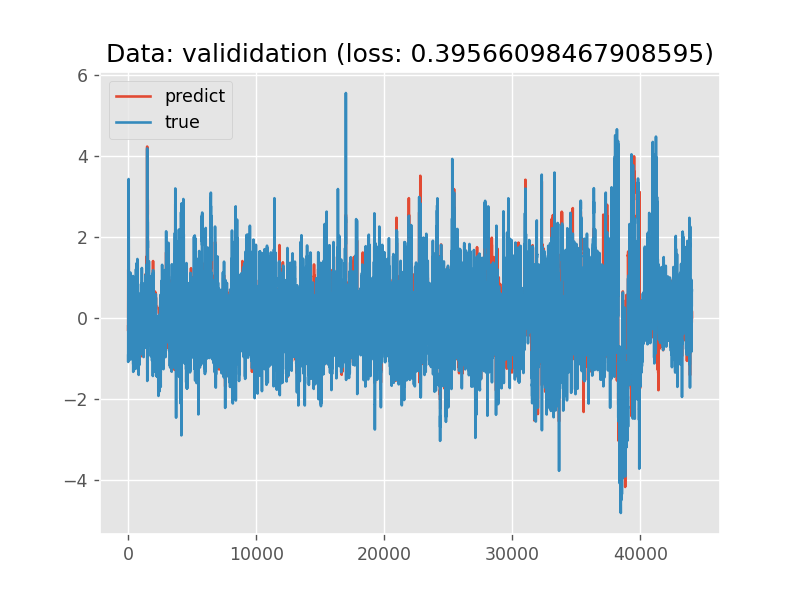

In [11]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = False
    
if trainPlotFlag:
    x = trainXTensor
    trainTitle = 'train'
else:
    x = validXTensor
    trainTitle = 'valididation'

model.to('cpu')
predict = model(x).cpu().detach().numpy()
model.to(device)

if predict.shape[1] == 1:
    yPred = predict[:,0]
    if trainPlotFlag:
        yTrue = yTrainTimeDomain[:,0]
    else:
        yTrue = yValidTimeDomain[:,0]
else:
    _, yPred = realSTFTtoTimeSeries(predict)
    if trainPlotFlag:
        y = y_trainRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
    else:
        y = y_validRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
        

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'Data: ' + trainTitle + ' (loss: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

# GET BEST MODEL DATA FROM NEPTUNE

In [9]:
sdm.neptuneBestRun()

https://new-ui.neptune.ai/jettinger35/predictScalp/


,sys/id,best_test_loss
0,PRED-66,0.389803
1,PRED-65,0.677281
2,PRED-64,0.648604
3,PRED-63,0.665345
4,PRED-62,0.676881
5,PRED-61,0.666001
6,PRED-60,0.674732
7,PRED-59,0.391365
12,PRED-54,0.391573
13,PRED-53,0.423721


# SCRATCH

In [ ]:
from scipy.signal import spectrogram, stft, istft, check_NOLA

fs = 1
nperseg = 32
noverlap = 31
#windowType = ('tukey', .25)
windowType = np.ones(nperseg)


a = np.random.rand(100)
f, t, S = stft(a, fs=fs, window=windowType, nperseg=nperseg, noverlap=noverlap)

b = torch.stft(torch.tensor(a), 
               n_fft = nperseg, 
               hop_length = 1, 
               return_complex=True, 
               normalized=False, 
               onesided=True, 
               pad_mode='constant').numpy()

np.abs(np.divide(b,S))

In [ ]:
from scipy.signal import get_window
a = get_window(('tukey', .25), nperseg)
a

In [ ]:
'''
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)
    
    
# GIVEN A LIST OF LAYER SIZES MAKE AN ORDERED DICTIONARY FOR INITIALIZING A PYTORCH NET

def listToOrderedDict(sizeList):
    n = len(sizeList)
    tupleList = []
    for i in range(n - 1):
        tupleList.append(('bn%s' % str(i), nn.BatchNorm1d(sizeList[i])))
        tupleList.append(('l%s' % str(i), nn.Linear(sizeList[i], sizeList[i+1])))
        tupleList.append(('r%s' % str(i), nn.ReLU()))
    return OrderedDict(tupleList[:-1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
'''

'''
    layerSizeList = [trainXTensor.shape[1]] + hiddenLayerSizes + [trainYTensor.shape[1]]
    layerOrderedDict = sdm.listToOrderedDict(layerSizeList)
    model = sdm.NeuralNetwork(layerOrderedDict)
    '''